***Final Tutorial***

For our final tutorial, we chose to analyze data from Capital One on Airbnb listings. We analyze how various factors, such as number of bedrooms, amenities, size of the listing, etc. affect pricing. 

In [116]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import xml.etree.ElementTree as ET
import seaborn as sns
import folium
from folium import plugins
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy.polynomial.polynomial as poly
warnings.filterwarnings('ignore')

In [79]:
calendar = pd.read_csv('calendar.csv')
calendar.head()

,listing_id,date,available,price
0,10988680,2018-04-01,f,NaN
1,10988680,2018-03-31,f,NaN
2,10988680,2018-03-30,f,NaN
3,10988680,2018-03-29,f,NaN
4,10988680,2018-03-28,f,NaN


In [82]:
listings = pd.read_csv('listings.csv')
listings = listings.rename(columns={"id": "listing_id"})
listings.head()

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,10988680,https://www.airbnb.com/rooms/10988680,20170401232214,2017-04-02,"Simple, new, clean accommodation",I signed a new lease and moving out of my plac...,"This is clean, simple, affordable accommodatio...",I signed a new lease and moving out of my plac...,none,Place is very conveniently located in the Miss...,...,10.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,0.07
1,8053481,https://www.airbnb.com/rooms/8053481,20170401232214,2017-04-02,Spacious 2BR/2BATH w/Shared Kitchen,Enjoy the whole main floor of our sunny 2-leve...,"We love our big, bright home and we know you w...",Enjoy the whole main floor of our sunny 2-leve...,none,Our Mission District neighborhood is among the...,...,9.0,f,NaN,SAN FRANCISCO,f,strict,f,f,1,0.49
2,14011173,https://www.airbnb.com/rooms/14011173,20170401232214,2017-04-02,Private room - Victorian House in the Mission,Awesome location in the Mission District of SF...,NaN,Awesome location in the Mission District of SF...,none,NaN,...,9.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,3,0.27
3,16142131,https://www.airbnb.com/rooms/16142131,20170401232214,2017-04-02,Spacious 1BR in the Mission District,"Quiet 1 bedroom apartment, with a spacious, we...",NaN,"Quiet 1 bedroom apartment, with a spacious, we...",none,NaN,...,8.0,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,0.48
4,9080622,https://www.airbnb.com/rooms/9080622,20170401232214,2017-04-02,Edwardian flat in heart of Mission,Bedroom with queen bed available. The condo i...,NaN,Bedroom with queen bed available. The condo i...,none,NaN,...,NaN,f,NaN,SAN FRANCISCO,f,flexible,f,f,1,NaN


In [83]:
reviews = pd.read_csv('reviews.csv', index_col=None)
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7025250,36355262,2015-06-27,49913,Sean,Kevin was quick to respond and very coordinati...
1,7025250,36495849,2015-06-28,17344420,Terry,"Kevin, my host, was not home but stayed in tou..."
2,7025250,40263555,2015-07-29,38552007,Jon,I have to say that after staying in 3 hotels i...
3,7025250,55069111,2015-11-27,30440816,Sean,Clean room. The room I stayed in had a privat...
4,7025250,55166030,2015-11-28,33218898,Gregg,Very relaxed and casual atmosphere. The space ...


In [84]:
listings.columns

Index(['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bat

In [149]:
locations = listings[['latitude', 'longitude', 'price']].dropna()
locations['price'] = [float(x[1:].replace(',', '')) for x in locations['price']]
locations.head()

,latitude,longitude,price
0,37.754184,-122.406514,49.0
1,37.754166,-122.421534,220.0
2,37.758506,-122.406152,100.0
3,37.756549,-122.422025,117.0
4,37.760051,-122.421352,200.0


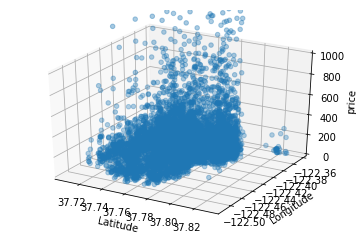

In [150]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

lat_coord = locations['latitude'][:30000]
long_coord = locations['longitude'][:30000]
price_coord = locations['price'][:30000]

ax.scatter(lat_coord, long_coord, price_coord)
ax.set_zlim([0, 1000])
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('price')

plt.show()

In [151]:
size_rating = listings[['square_feet', 'review_scores_rating']].dropna()
print(size_rating.shape)
size_rating.head()

(177, 2)


,square_feet,review_scores_rating
35,500.0,93.0
65,170.0,100.0
115,600.0,100.0
124,1100.0,95.0
132,950.0,98.0


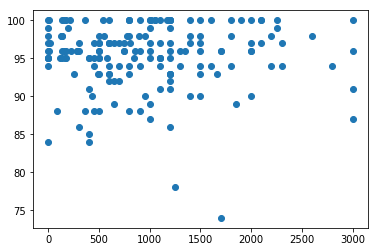

In [152]:
plt.scatter(size_rating['square_feet'], size_rating['review_scores_rating'])
plt.show()

In [153]:
price_ratings = listings[['listing_id', 'price', 'review_scores_rating']].dropna()
print(price_ratings.shape)
price_ratings.head()

(6655, 3)


,listing_id,price,review_scores_rating
0,10988680,$49.00,100.0
1,8053481,$220.00,96.0
2,14011173,$100.00,90.0
3,16142131,$117.00,100.0
5,936209,$162.00,96.0


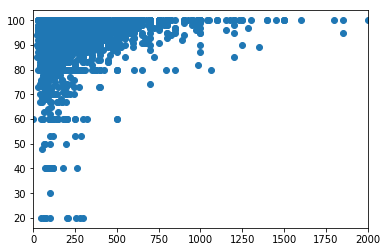

In [154]:
price_ratings['price'] = [float(x[1:].replace(',','')) for x in price_ratings['price']]
plt.scatter(price_ratings['price'], price_ratings['review_scores_rating'])
plt.xlim([0, 2000])
plt.show()

In [155]:
bedroom_price = listings[['listing_id', 'bedrooms', 'price']].dropna()
print(bedroom_price.shape)
bedroom_price.head()

(8698, 3)


,listing_id,bedrooms,price
0,10988680,1.0,$49.00
1,8053481,2.0,$220.00
2,14011173,1.0,$100.00
3,16142131,1.0,$117.00
4,9080622,1.0,$200.00


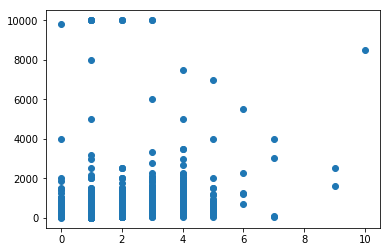

In [156]:
bedroom_price['price'] = [float(x[1:].replace(',','')) for x in bedroom_price['price']]
plt.scatter(bedroom_price['bedrooms'], bedroom_price['price'])
plt.show()

[169.53218495013598, 340.9775967413442, 515.85185185185185, 203.6103896103896, 778.10666666666668, 1033.25, 2177.8000000000002, 8500.0, 1804.5, 2050.0]
[1.0, 2.0, 3.0, 0.0, 4.0, 5.0, 6.0, 10.0, 7.0, 9.0]


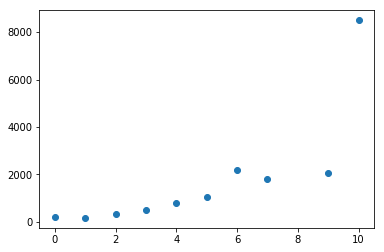

In [157]:
bedavg = []
numrooms = []
for x in bedroom_price['bedrooms'].unique():
    bedavg.append(bedroom_price[bedroom_price['bedrooms'] == x]['price'].mean())
    numrooms.append(x)
print(bedavg)
print(numrooms)
plt.scatter(numrooms, bedavg)
plt.show()

In [158]:
min_x, rng_x = (np.min(numrooms), np.max(numrooms) - np.min(numrooms))
x = 2*(numrooms - min_x) / rng_x - 1.0
X = np.vstack([x**i for i in range(2,-1,-1)]).T
theta = np.linalg.solve(X.T.dot(X), X.T.dot(bedavg))

In [159]:
theta

array([ 2597.73134717,  2841.51169933,   878.37010669])

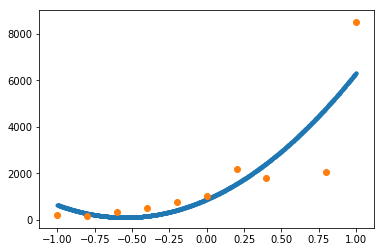

In [160]:
x0 =2*(np.linspace(min_x, min_x+rng_x, 1000) - min_x)/rng_x - 1.0
y0 = [0 for i in range(len(x0))]

for i in range(len(x0)):
    y0[i] = x0[i]**2 * theta[0] + x0[i] * theta[1] + theta[2]

plt.scatter(x0, y0, marker='.')
plt.scatter(x, bedavg)
plt.show()

In [161]:
error = 0
for i in range(len(x)):
    y_pred = i**2 * theta[0] + i*theta[1] + theta[2]
    error += (y_pred - bedavg[i])**2 / len(x)
print('Mean squared error: ', error)

Mean squared error:  13234261975.8


In [124]:
error = 0
for i in range(len(x)):
    y_pred = ffit[i]
    error += (y_pred - bedavg[i])**2 / len(x)
print('Mean squared error: ', error)

Mean squared error:  1372305.59459


In [162]:
def r_squared(n, x, y):
    sum_xy = 0
    for i in range(n):
        sum_xy += x[i]*y[i]
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum([i**2 for i in x])
    sum_y2 = np.sum([i**2 for i in y])
    
    r = (n*sum_xy - sum_x*sum_y)
    r /= (n*sum_x2 - sum_x**2)*(n*sum_y2 - sum_y**2)
    
    return r**2

In [163]:
r_squared(len(x), x, ffit)

1.0779197538063816e-12

In [164]:
size_price = listings[['listing_id', 'square_feet', 'price']].dropna()
size_price['price'] = [float(x[1:].replace(',','')) for x in size_price['price']]
print(size_price.shape)
size_price.head()

(184, 3)


,listing_id,square_feet,price
35,63405,500.0,125.0
65,815123,170.0,130.0
75,223213,1100.0,450.0
94,486950,1400.0,100.0
115,58756,600.0,127.0


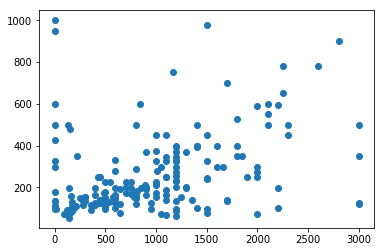

In [165]:
# try and see if there is a relationship between size of place and the price of it.
plt.scatter(size_price['square_feet'], size_price['price'])
plt.show()

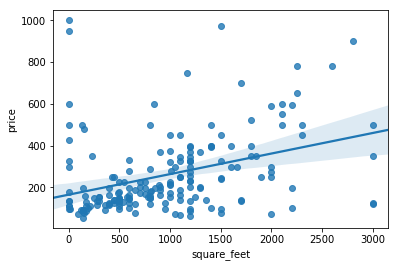

In [166]:
sns.regplot(x='square_feet', y='price', data=size_price)
plt.show()

In [167]:
x_train = size_price['square_feet']
y_train = size_price['price']

ols = linear_model.LinearRegression()
model = ols.fit(x_train.values.reshape(-1,1), y_train)
print("intercept: ", model.intercept_, "slope: ", model.coef_[0])
y_pred = model.predict(x_train.values.reshape(-1,1))
print("mean squared error: ", mean_squared_error(y_train, y_pred))
print("r^2 value: ", r2_score(y_train, y_pred))

intercept:  165.362043425 slope:  0.0985059258354
mean squared error:  30101.8244725
r^2 value:  0.136046441209


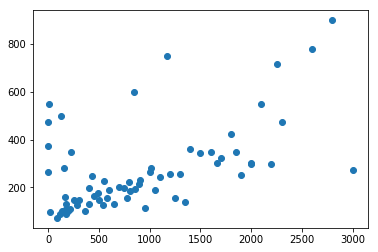

In [168]:
meanprice = []
sizes = []
for x in size_price['square_feet'].unique():
    meanprice.append(size_price[size_price['square_feet'] == x]['price'].mean())
    sizes.append(x)

plt.scatter(sizes, meanprice)
plt.show()

In [169]:
data = listings[['square_feet', 'bedrooms', 'price']].dropna()
data['bedrooms'] = [str(x) for x in data['bedrooms']]
print(data.shape)
print(data['square_feet'].shape)
print(data['bedrooms'].shape)
print(data['price'].shape)

(184, 3)
(184,)
(184,)
(184,)


In [40]:
# DO THIS PART ANMOL

#regression = smf.ols(formula='price ~ square_feet*bedrooms', data=data).fit()
#regression.summary()

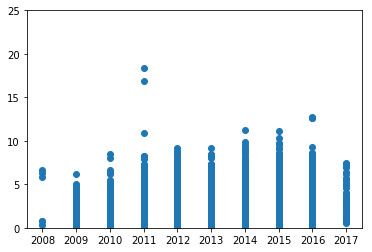

In [172]:
reviews = listings[['host_since', 'reviews_per_month']].dropna()
reviews['host_since'] = [x[:4] for x in reviews['host_since']]
reviews.head()
plt.scatter(reviews['host_since'], reviews['reviews_per_month'])
plt.ylim([0,25])
plt.show()

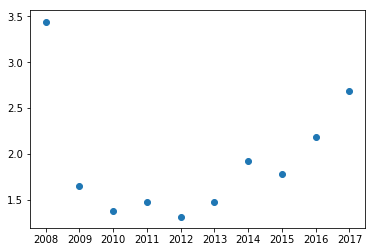

In [173]:
revavg = []
year = []
for x in reviews['host_since'].unique():
    revavg.append(reviews[reviews['host_since'] == x]['reviews_per_month'].mean())
    year.append(x)
plt.scatter(year, revavg)
plt.show()

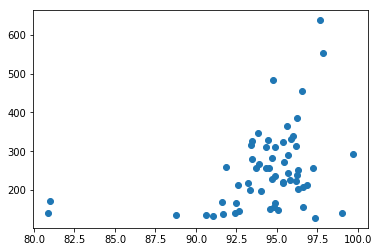

In [174]:
x = []
avgprice = []
y = []

for a in nprice['neighbourhood'].unique():
    x.append(ratings[ratings['neighbourhood'] == a]['review_scores_rating'].mean())
    avgprice.append(x[-1])
    y.append(nprice[nprice['neighbourhood'] == a]['price'].mean())
    
plt.scatter(x, y)
plt.show()
    

In [175]:
min_x, rng_x = (np.min(x), np.max(x) - np.min(x))
x = 2*(x - min_x) / rng_x - 1.0

X = np.vstack([x**i for i in range(2,-1,-1)]).T
theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))

In [176]:
theta

array([  62.62190223,  110.76292839,  185.63958079])

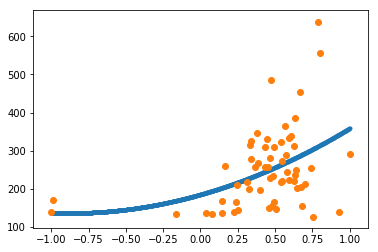

In [177]:
x0 =2*(np.linspace(min_x, min_x+rng_x, 1000) - min_x)/rng_x - 1.0
y0 = [0 for i in range(len(x0))]

for i in range(len(x0)):
    y0[i] = x0[i]**2 * theta[0] + x0[i] * theta[1] + theta[2]

plt.scatter(x0, y0, marker='.')
plt.scatter(x, y)
plt.show()

In [179]:
#listing_locs = listings[['latitude', 'longitude']].as_matrix()
# map_osm.add_children(plugins.HeatMap(listing_locs, radius=15))

listing_locs = listings[['latitude', 'longitude', 'price']]
listing_locs['price'] = [float(x[1:].replace(',','')) for x in listing_locs['price']]
lats = listing_locs['latitude'].values
longs = listing_locs['longitude'].values
mag = listing_locs['price'].values

In [182]:
map_osm = folium.Map(location=[lats[0], longs[0]], zoom_start=12)

i = 0
data = []
maxPrice = max(mag)

while i < len(lats):
    data.append([lats[i], longs[i], mag[i]/maxPrice])
    i+=1

    

map_osm.add_children(plugins.HeatMap(data, radius=15))
map_osm